In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC


In [ ]:
!pip install transformers

In [ ]:
import torch
import pandas as pd
import numpy as np

# Thu vien transformer cho Classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, XLMRobertaForSequenceClassification, RobertaForSequenceClassification

# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset"

In [ ]:
train = pd.read_csv(path + "/UIT-VSFC/VSFC_train.csv", index_col=False)
dev = pd.read_csv(path + "/UIT-VSFC/VSFC_dev.csv", index_col=False)
test = pd.read_csv(path + "/UIT-VSFC/VSFC_test.csv", index_col=False)

In [ ]:
%cd "/content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC/Sentiment"

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Tu_PhoBert/UIT-VSFC/Sentiment


In [ ]:
X_train = train['Sents']
y_train = train['Sentiments'].values

X_dev = dev['Sents']
y_dev = dev['Sentiments'].values

X_test = test['Sents']
y_test = test['Sentiments'].values

In [ ]:
# encoding label 
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [ ]:
num_labels = len(np.unique(y_test))

In [ ]:
path_model = ""

In [ ]:
phobert = RobertaForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = num_labels)
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

In [ ]:
train_encodings = phobert_tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = phobert_tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = phobert_tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [ ]:
# Chuan bi data

train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

In [ ]:
# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results_1',          
    num_train_epochs=25,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

phobert_trainer = Trainer(
    model=phobert,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
phobert_trainer.train()

Step,Training Loss
500,0.396800
1000,0.189800
1500,0.129200
2000,0.085900
2500,0.071500
3000,0.045600
3500,0.030700
4000,0.024200
4500,0.014600
5000,0.013500


TrainOutput(global_step=8950, training_loss=0.058003823764663835, metrics={'train_runtime': 4517.3265, 'train_samples_per_second': 63.234, 'train_steps_per_second': 1.981, 'total_flos': 9255099693924000.0, 'train_loss': 0.058003823764663835, 'epoch': 25.0})

In [ ]:
# Du doan 
y_pred_classify = phobert_trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
# Danh gia mo hinh
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_true = y_test_encoding

cf = confusion_matrix(y_true, y_pred)
print(cf)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

print("accuracy: " + str(accuracy_score(y_true, y_pred)))

[[1358   15   36]
 [  32   82   53]
 [  60   22 1508]]
F1 - micro: 0.9311433986102339
F1 - macro: 0.8232512031418331
accuracy: 0.9311433986102338


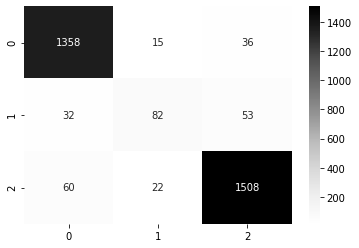

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})